# WER on single recording end to end

#### Common packages

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib notebook
import matplotlib.pylab as plt
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore")
from graphviz import Digraph
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

## Amharic

In [4]:
from Cfg import Cfg
C = Cfg('NIST', 8000, 'amharic') 

## Split Corpus into Recordings $\langle A_i,T_i \rangle$

In [ ]:
import split_corpus_into_recordings
split_corpus_into_recordings.diagram(C)

In [ ]:
from RecordingCorpus import RecordingCorpus
from multiprocessing import Pool
from contextlib import closing
if __name__ == '__main__':
    with closing(Pool(16)) as pool:
        recordings = RecordingCorpus(C, pool)

In [ ]:
id_recording={x.key:x for x in recordings.artifacts}

## Split Recordings $\langle A_i,T_i \rangle$ into Splits $\langle A_{i,j}, T_{i,j} \rangle$ 

In [ ]:
import split_recordings_into_splits
split_recordings_into_splits.diagram(C)

In [ ]:
from SplitCorpus import SplitCorpus
splits=SplitCorpus.from_recordings(C, recordings)

In [ ]:
id_splits={x.key:x for x in splits.artifacts}

## Subsplit $A_{i,j}$ on silence and apportion text to trimmed chunks by word sizes in $T_{i,j} = \langle w_{i,j,k} \rangle$ where $w_{i,j,k}=\langle g_{i,j,k,l} \rangle$

In [ ]:
import subsplit_Aij_on_silence_and_apportion_text_by_size
subsplit_Aij_on_silence_and_apportion_text_by_size.diagram

In [ ]:
from SubSplitCorpus import SubSplitCorpus
if __name__=="__main__":
    if False:
        with closing(Pool(16)) as pool:
            subsplits=SubSplitCorpus(pool, splits, min_words=2)
        with open('bfgpu.pkl', 'wb') as f:
            pickle.dump(subsplits,f)
    else:
        with open('bfgpu.pkl', 'rb') as f:
            subsplits=pickle.load(f)

In [ ]:
id_subsplits={x.key:x for x in subsplits.artifacts}

# Train ASR NN on subsplits $\langle A_{i,j,k}, T_{i,j,k} \rangle$ inferring $P_{i,j,k}$

In [ ]:
import train_ASR_NN_on_subsplits
train_ASR_NN_on_subsplits.diagram

In [ ]:
import os
os.environ['IN_JUPYTER']='True'

In [ ]:
from ASR_NN import ASR_NN
model_ASR = ASR_NN(C);
model_ASR.load_model();
model_ASR.load_training_set(subsplits, batch_size=24)
ASR_output = model_ASR.infer()
ASR_scores = model_ASR.score(ASR_output)

Clean up GPU memory for next phase

In [ ]:
import torch
del model_ASR
torch.cuda.empty_cache() 

## Concatenate $P_{i,j,k}$ giving $P_{i,j} = P_{i,j,1}\|\cdots\|P_{i,j,-1}$

In [ ]:
import concatenate_Pikj_giving_Pij
concatenate_Pikj_giving_Pij.diagram

In [ ]:
for order, hyp in ASR_scores[['order','hyp']].values:
    subsplits.artifacts[order].P = hyp

In [ ]:
Pij={x.key[0:-1]:{} for x in subsplits.artifacts}

for x in subsplits.artifacts:
    Pij[x.key[0:-1]][x.key[-1]] = x.P

for key in Pij:
    Pij[key] = ' '.join([y for x,y in Pij[key].items()])

for key in Pij:
    id_splits[key].P=Pij[key]

## Join text corrector training sets $\langle P_{i,j,k}, T_{i,j,k}\rangle$ and $\langle P_{i,j}, T_{i,j}\rangle$ giving training set $\langle P, T\rangle$

In [ ]:
import join_Pijk_and_Pij_giving_P
join_Pijk_and_Pij_giving_P.diagram

In [ ]:
Pijk_Tijk=[(x.P, x.target.value, x) for x in subsplits.artifacts]
In [ ]:
￼
import score_TiQi_using_sclite_on_all_recordings_together
score_TiQi_using_sclite_on_all_recordings_together.diagram
In [ ]:
￼
​


In [ ]:
Pij_Tij=[(y.P, y.target.value, y) for x,y in id_splits.items() if 'P' in vars(y)]

In [ ]:
P_T=Pijk_Tijk+Pij_Tij

In [ ]:
!ls -l pt.pkl

In [5]:
if False:
    with open('pt.pkl', 'wb') as f:
        pickle.dump(P_T, f)
else:
    with open('pt.pkl', 'rb') as f:
        P_T = pickle.load(f)

## Infer text-to-text corrector $P\to Q\approx T$ and score

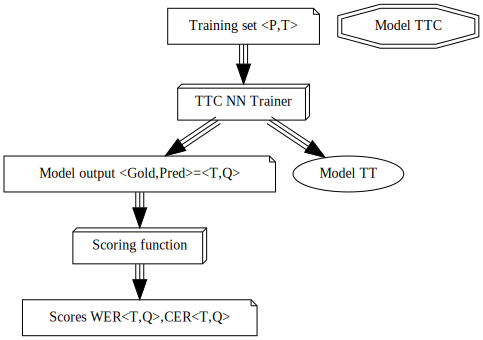

In [6]:
import train_text_to_text_corrector_on_PQT_score
train_text_to_text_corrector_on_PQT_score.diagram

In [7]:
from TTC_NN import TTC_NN

In [8]:
model_TTC = TTC_NN(C);

In [9]:
model_TTC.load_training_set(P_T, 64)

INFO:root:Batch size 64
INFO:root:#Training examples 45208
INFO:root:#graphemes 235


In [10]:
model_TTC.load_model('save/afterburner/afterburner_002_94804_9.pt');

The model has 4,399,599 trainable parameters


707 batches / epoch


<IPython.core.display.Javascript object>


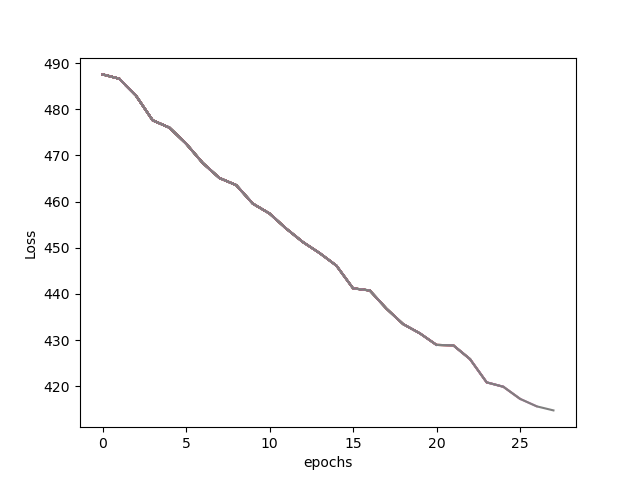

saved save/afterburner/afterburner_002_96473_38.pt
saved save/afterburner/afterburner_002_96473_39.pt
saved save/afterburner/afterburner_002_96473_40.pt
saved save/afterburner/afterburner_002_96473_41.pt
saved save/afterburner/afterburner_002_96473_42.pt
saved save/afterburner/afterburner_002_96473_43.pt
saved save/afterburner/afterburner_002_96473_44.pt
saved save/afterburner/afterburner_002_96473_45.pt
saved save/afterburner/afterburner_002_96473_46.pt
saved save/afterburner/afterburner_002_96473_47.pt
saved save/afterburner/afterburner_002_96473_48.pt
saved save/afterburner/afterburner_002_96473_49.pt
saved save/afterburner/afterburner_002_96473_50.pt
saved save/afterburner/afterburner_002_96473_51.pt
saved save/afterburner/afterburner_002_96473_52.pt
saved save/afterburner/afterburner_002_96473_53.pt
saved save/afterburner/afterburner_002_96473_54.pt
saved save/afterburner/afterburner_002_96473_55.pt
saved save/afterburner/afterburner_002_96473_56.pt
saved save/afterburner/afterbur

In [ ]:
model_TTC.train(1)

In [ ]:
TTC_output = model_TTC.infer()

In [ ]:
TTC_scores = model_TTC.score(TTC_output)

In [ ]:
model.graphemes

In [ ]:
torch.cuda.empty_cache()

## Subsplit $A_{i,j}$ on silence alone retaining timecode $(s_{i,j,k},e_{i,j,k})$ giving $A_{i,j} = \langle (\alpha_{i,j,k}, (s_{i,j,k},e_{i,j,k})) \rangle$ so that $\alpha_{i,j,k} = A_{i,j}[s_{i,j,k}:e_{i,j,k}]$

In [ ]:
import subsplit_Aij_on_silence_retaining_timecode
subsplit_Aij_on_silence_retaining_timecode.diagram

## Infer $(\alpha_{i,j,k}, (s_{i,j,k},e_{i,j,k})) \xrightarrow{ASR} p_{i,j,k} $

In [ ]:
import infer_aijk_giving_pijk
infer_aijk_giving_pijk.diagram

In [ ]:
torch.cuda.empty_cache() 

## Concatenate $p_{i,j,k} \to p_{i,j}$

In [ ]:
import concatenate_pikj_giving_pij
concatenate_pikj_giving_pij.diagram

## Infer $p_{i,j} \xrightarrow{TT} (q_{i,j},(s_{i,j,0},e_{i,j,-1}))$ 

In [ ]:
import infer_pij_giving_qij
infer_pij_giving_qij.diagram

In [ ]:
torch.cuda.empty_cache() 

## Concatenate $\langle \langle (q_{i,j,k},(s_{i,j,k},e_{i,j,k})) \rangle \rangle $ giving transcript $Q_i = \langle (q_{i,j}, (s_{i,j,0},e_{i,j,-1})) \rangle$

In [ ]:
import concatenate_qijk_giving_Qi
concatenate_qijk_giving_Qi.diagram

## Save transcript $Q_i$ in .CTM format

In [ ]:
import save_transcript_Qi_in_CTM_format
save_transcript_Qi_in_CTM_format.diagram

## Score $\langle T_i,Q_i\rangle$ using `sclite` for each recording individually

In [ ]:
import score_TiQi_using_sclite_per_recording
score_TiQi_using_sclite_per_recording.diagram

## Score $\langle T_i,Q_i\rangle$ using `sclite` collectively

In [ ]:
import score_TiQi_using_sclite_on_all_recordings_together
score_TiQi_using_sclite_on_all_recordings_together.diagram